## Capstone Project:    Battle of the Neighborhoods: Vietnamese Restaurants
    
    
    
Which neighborhoods and boroughs in New York City have the most and best Vietnamese Restaurants?
Where should a Vietnamese restaurant be opened as a new business?
    
Data Used
Data including New York City neighborhoods, boroughs to include boundaries, latitude, longitude, restaurants, and restaurant ratings and tip will be utilized.

New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset


The FourSquare API will be used to get locations and quality of Vietnamese restaurants in New York City.

Methodology
• Data will be collected from https://cocl.us/new_york_dataset and cleaned and processed into a dataframe.

• FourSquare be used to locate all venues and then filtered by Vietnamese restaurants. Ratings, tips, and likes by users will be counted and added to the dataframe.

• Data will be sorted based on rankings

• Finally, the data be will be visually assessed using graphing from various Python libraries.

Problem Statement
Where is best location(s) for Vietnamese cuisine in New York City?
In what Neighborhood and/or borough should I open a Vietnamese restaurant?
Where in New York City has the best Vietnamese food?

In [1]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Everything was installed successfully')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

My Hidden Foursquare Credentials

In [13]:
# The code was removed by Watson Studio for sharing.

imported json and json_normalize


In [4]:
def geo_location(address):
    # Get coordinates location of address
    geolocator = Nominatim(user_agent="my_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [14]:
def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    # Obtain data from foursquare
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # collect the data to be analyzed
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    venue_df = pd.DataFrame(venue_details,columns=column_names)
    return venue_df

In [15]:
def get_venue_details(venue_id):
    # Obtain data from foursquare
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # Obtain data from foursquare
    foursq_results = requests.get(url).json()
    print(foursq_results)
    venue_data=foursq_results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    details_df = pd.DataFrame(venue_details,columns=column_names)
    return details_df

In [16]:
def get_ny_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # All of the data is present in features label
    features=resp['features']
    # Dataframe columns defined for use
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # startup the dataframe
    ny_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        ny_data = ny_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return ny_data

Obtain New York City data

In [9]:
nyc_data = get_ny_data()
nyc_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
nyc_data.shape

(306, 4)

Analyze Data: Manhattan has the least number of neighborhoods in all five boroughs.

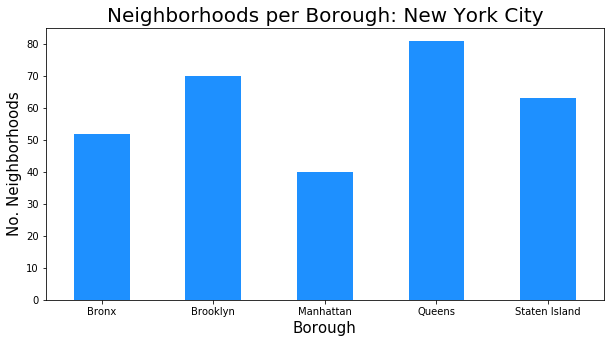

In [11]:
clr = "dodgerblue"
nyc_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: New York City', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()


Further analysis: How many Vietnamese restaurants are there in each neighborhood and borough?
Graph the results.

In [17]:
# 
# Prepare the neighborhood list that contains Vietnamese Restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
vietnamese_nyc=pd.DataFrame(columns=column_names)
count=1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    vietnamese_rest=venues[venues['Category']=='Vietnamese Restaurant']   
    print('(',count,'/',len(nyc_data),')','Vietnamese Restaurants in '+Neighborhood+', '+Borough+':'+str(len(vietnamese_rest)))
    print(row)
    for restaurant_detail in vietnamese_rest.values.tolist():
        id, name , category=restaurant_detail
        vietnamese_nyc = vietnamese_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Vietnamese Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Vietnamese Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Vietnamese Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Vietnamese Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Vietnamese Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Vietnamese Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Vietnamese Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Vietnamese Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Vietnamese Restaur

In [18]:
# Save the information so far to a .csv file
vietnamese_nyc.to_csv('viet_nyc_csv.csv', index=False) 

In [19]:
#vietnamese_nyc = pd.read_csv('viet_nyc_csv.csv')
vietnamese_nyc.tail()

,Borough,Neighborhood,ID,Name
20,Staten Island,New Dorp,54f82191498e79d55c3ae3e6,Pho Rainbow
21,Manhattan,Carnegie Hill,55fee83e498ed70032cf4313,Le Viet Café
22,Queens,Hunters Point,502e7165e4b0f9a2dcd8ea33,Cyclo
23,Manhattan,Tudor City,5c1a6dd6121384002ce93aff,Sai Gon Dep
24,Brooklyn,Homecrest,4aecde90f964a520e7cb21e3,Phở Vietnam


In [20]:
vietnamese_nyc.shape

(25, 4)

Analysis: Manhattan, a borough, has the least number of neighborhoods, but it does have the highest number of Vietnamese restaurants as indicated below.

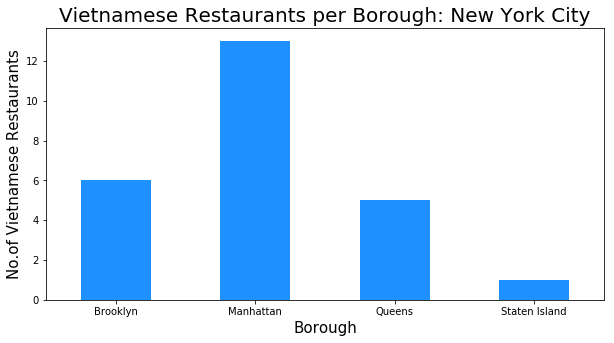

In [21]:
vietnamese_nyc.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color = clr)
plt.title('Vietnamese Restaurants per Borough: New York City', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Vietnamese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Analysis:  Additionally, we see how many restaurants the top 6 neighborhoods have. As indicated below, the neighborhood of Chinatown has the highest number of Vietnamese restaurants in all of New York City and is actually located in the borough Manhattan.

In [ ]:
NumbofNeighb = 6 # How many restaurants the top six neighborhoods have
vietnamese_nyc.groupby('Neighborhood')['ID'].count().nlargest(NumbofNeighb).plot.bar(figsize=(10,5), color=clr)
plt.title('Vientnamese Restaurants per Neighborhood: New York City', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Vietnamese Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Chinatown has a higher concentration of Vietnamese restaurants as indicated below.

In [23]:
vietnamese_nyc[vietnamese_nyc['Neighborhood']=='Chinatown']
vietnamese_nyc

,Borough,Neighborhood,ID,Name
0,Brooklyn,Greenpoint,5aa427100a464d2cf717b688,Đi ăn Đi
1,Brooklyn,Brooklyn Heights,4e43d56baeb7d02fd0e2fa63,Hanco's
2,Brooklyn,Fort Greene,592f635bb399f77e5738c416,Mekong BK
3,Brooklyn,Downtown,5959658aa4ba7c5751ff1330,Bunker
4,Brooklyn,South Side,5c846de85c6838002c348898,High Lúa Vietnamese Kitchen
5,Manhattan,Chinatown,4388f700f964a520162b1fe3,Phở Grand
6,Manhattan,Chinatown,4a7e3d0cf964a52088f11fe3,Nam Son Vietnamese Restaurant
7,Manhattan,Chinatown,53aee20d498e6744c341c483,Pho Vietnam
8,Manhattan,Yorkville,57cde924498e8a03be8925a9,Pho Shop
9,Manhattan,Midtown,5d9629652e04ea000834556a,Joju


Pull in information regarding tips, likes, ratings.

In [24]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
viet_stats_nyc=pd.DataFrame(columns=column_names)
count=1
for row in vietnamese_nyc.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # 0 will be assigned to these restaurants because they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(vietnamese_nyc),')','processed')
    viet_stats_nyc = viet_stats_nyc.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
viet_stats_nyc.tail()

{'meta': {'code': 200, 'requestId': '5e275f4b6001fe001b5bb8ba'}, 'response': {'venue': {'id': '5aa427100a464d2cf717b688', 'name': 'Đi ăn Đi', 'contact': {'instagram': 'diandi.nyc'}, 'location': {'address': '68 Greenpoint Ave', 'lat': 40.7298006838517, 'lng': -73.9582564594443, 'labeledLatLngs': [{'label': 'display', 'lat': 40.7298006838517, 'lng': -73.9582564594443}], 'postalCode': '11222', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['68 Greenpoint Ave', 'New York, NY 11222', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/%C4%91i-%C4%83n-%C4%91i/5aa427100a464d2cf717b688', 'categories': [{'id': '4bf58dd8d48988d14a941735', 'name': 'Vietnamese Restaurant', 'pluralName': 'Vietnamese Restaurants', 'shortName': 'Vietnamese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/vietnamese_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d48988d1d1941735', 'name': 'Noodle House', 'pluralName': 'Noodle Houses', 

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
20,Staten Island,New Dorp,54f82191498e79d55c3ae3e6,Pho Rainbow,10,5.9,5
21,Manhattan,Carnegie Hill,55fee83e498ed70032cf4313,Le Viet Café,14,7.6,4
22,Queens,Hunters Point,502e7165e4b0f9a2dcd8ea33,Cyclo,257,8.5,98
23,Manhattan,Tudor City,5c1a6dd6121384002ce93aff,Sai Gon Dep,42,9.0,13
24,Brooklyn,Homecrest,4aecde90f964a520e7cb21e3,Phở Vietnam,37,7.2,18


In [25]:
viet_stats_nyc


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Greenpoint,5aa427100a464d2cf717b688,Đi ăn Đi,164,8.9,39
1,Brooklyn,Brooklyn Heights,4e43d56baeb7d02fd0e2fa63,Hanco's,212,7.7,68
2,Brooklyn,Fort Greene,592f635bb399f77e5738c416,Mekong BK,35,8.4,8
3,Brooklyn,Downtown,5959658aa4ba7c5751ff1330,Bunker,23,6.5,4
4,Brooklyn,South Side,5c846de85c6838002c348898,High Lúa Vietnamese Kitchen,16,7.7,7
5,Manhattan,Chinatown,4388f700f964a520162b1fe3,Phở Grand,382,8.2,133
6,Manhattan,Chinatown,4a7e3d0cf964a52088f11fe3,Nam Son Vietnamese Restaurant,202,8.3,61
7,Manhattan,Chinatown,53aee20d498e6744c341c483,Pho Vietnam,128,7.7,21
8,Manhattan,Yorkville,57cde924498e8a03be8925a9,Pho Shop,58,8.2,18
9,Manhattan,Midtown,5d9629652e04ea000834556a,Joju,8,8.4,7


In [26]:

# Data will be saved to a .csv
viet_stats_nyc.to_csv('viet_stats_nyc_csv.csv') 

In [27]:
viet_stats_nyc.shape

(25, 7)

In [28]:
viet_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
Borough         25 non-null object
Neighborhood    25 non-null object
ID              25 non-null object
Name            25 non-null object
Likes           25 non-null object
Rating          25 non-null float64
Tips            25 non-null object
dtypes: float64(1), object(6)
memory usage: 1.4+ KB


In [29]:
viet_stats_nyc['Likes']=viet_stats_nyc['Likes'].astype('float64')
viet_stats_nyc['Tips']=viet_stats_nyc['Tips'].astype('float64')
viet_stats_nyc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
Borough         25 non-null object
Neighborhood    25 non-null object
ID              25 non-null object
Name            25 non-null object
Likes           25 non-null float64
Rating          25 non-null float64
Tips            25 non-null float64
dtypes: float64(3), object(4)
memory usage: 1.4+ KB


In [30]:
viet_stats_nyc.describe()

,Likes,Rating,Tips
count,25.000000,25.000000,25.000000
mean,125.160000,7.848000,43.240000
std,131.752824,0.967436,48.674326
min,6.000000,5.900000,2.000000
25%,23.000000,7.600000,7.000000
50%,58.000000,8.200000,19.000000
75%,212.000000,8.500000,61.000000
max,422.000000,9.000000,170.000000


In [41]:
# Vietnamese Restaurant with maximum Likes
viet_stats_nyc.iloc[viet_stats_nyc['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              3fd66200f964a52034eb1ee3
Name                            Phở Bằng
Likes                                422
Rating                               8.2
Tips                                 170
Name: 14, dtype: object

In [42]:
# Vietnamese Restaurant with maximum Ratings
viet_stats_nyc.iloc[viet_stats_nyc['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                 Murray Hill
ID              5c1a6dd6121384002ce93aff
Name                         Sai Gon Dep
Likes                                 42
Rating                                 9
Tips                                  13
Name: 10, dtype: object

In [43]:
# Vietnamese Restaurant with maximum Tips
viet_stats_nyc.iloc[viet_stats_nyc['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              3fd66200f964a52034eb1ee3
Name                            Phở Bằng
Likes                                422
Rating                               8.2
Tips                                 170
Name: 14, dtype: object

In [34]:
nyc_nhood_stats=viet_stats_nyc.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
nyc_nhood_stats.columns=['Neighborhood','Average Rating']
nyc_nhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
20,Tudor City,9.00
15,Murray Hill,9.00
8,Greenpoint,8.90
5,East Village,8.85
13,Manhattan Valley,8.80
10,Hunters Point,8.50
14,Midtown,8.40
7,Fort Greene,8.40
11,Little Italy,8.20
21,Yorkville,8.20


In [35]:
nyc_borough_stats=viet_stats_nyc.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
nyc_borough_stats.columns=['Borough','Average Rating']
nyc_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.369231
0,Brooklyn,7.733333
2,Queens,7.020000
3,Staten Island,5.900000


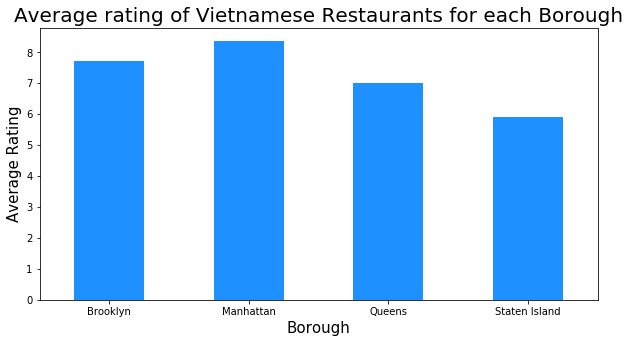

In [36]:
viet_stats_nyc.groupby('Borough').mean()['Rating'].plot.bar(figsize=(10,5), color=clr)
plt.title('Average rating of Vietnamese Restaurants for each Borough', fontsize=20)
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

Map Creation:
    Neighborhood Ratings greater than 8 will be visually mapped the neighborhoods after joining the appropriate dataframes to include latitudes and longitudes.

In [37]:
nyc_nhood_stats=nyc_nhood_stats[nyc_nhood_stats['Average Rating']>=8.0]
nyc_nhood_stats

,Neighborhood,Average Rating
3,Chinatown,8.066667
5,East Village,8.850000
7,Fort Greene,8.400000
8,Greenpoint,8.900000
10,Hunters Point,8.500000
11,Little Italy,8.200000
13,Manhattan Valley,8.800000
14,Midtown,8.400000
15,Murray Hill,9.000000
20,Tudor City,9.000000


In [38]:
nyc_nhood_stats=pd.merge(nyc_nhood_stats,nyc_data, on='Neighborhood')
nyc_nhood_stats=nyc_nhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
nyc_nhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Chinatown,40.715618,-73.994279,8.066667
1,Manhattan,East Village,40.727847,-73.982226,8.850000
2,Brooklyn,Fort Greene,40.688527,-73.972906,8.400000
3,Brooklyn,Greenpoint,40.730201,-73.954241,8.900000
4,Queens,Hunters Point,40.743414,-73.953868,8.500000
5,Manhattan,Little Italy,40.719324,-73.997305,8.200000
6,Manhattan,Manhattan Valley,40.797307,-73.964286,8.800000
7,Manhattan,Midtown,40.754691,-73.981669,8.400000
8,Manhattan,Murray Hill,40.748303,-73.978332,9.000000
9,Queens,Murray Hill,40.764126,-73.812763,9.000000


Create Map: A map of New York City will be created. The 12 boroughs will be plotted with their average ratings.

In [39]:
# Create map of New York City and display it
nyc_map = folium.Map(location=geo_location('New York'), zoom_start=12)

# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

for lat, lng, in nyc_nhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [45]:
nyc_nhood_stats['Label']=nyc_nhood_stats['Neighborhood']+', '+nyc_nhood_stats['Borough']+'('+nyc_nhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in nyc_nhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(nyc_map)        
# add incidents to map
nyc_map.add_child(incidents)

# Results / Conclusion
The boroughs of Manhattan and Brooklyn have the highest rated Vietnamese restaurants on average. Murray Hill, of Manhattan, rated the highest at 9.0.

Queens and Staten Islands have the least amount of Vietnamese restaurants per borough with the lowest average ratings that are above 8.0.

Although Manhattan has the least number of neighborhoods in all five boroughs, it has the most Vietnamese restaurants, meaning it is more concentrated which would pose a barrier to entry. 
On the other hand, the Bronx has 0 Vietnamese restaurants on as of 1/21/2020 according to Foursquare.

Based on this information, I would state that Manhattan and Brooklyn are the best locations for Vietnamese food cuisine in New York City because of the higher average ratings. I would open a Vietnamese restaurant in the Bronx because there are 0 restaurants as of today. The Bronx does not have a barrier to entry, unless the population does not like Vietnamese food. 

Finally, I would go to Pho Bang located in Little Italy in the Manhattan borough for the best Vietnamese food based on 422 likes. 